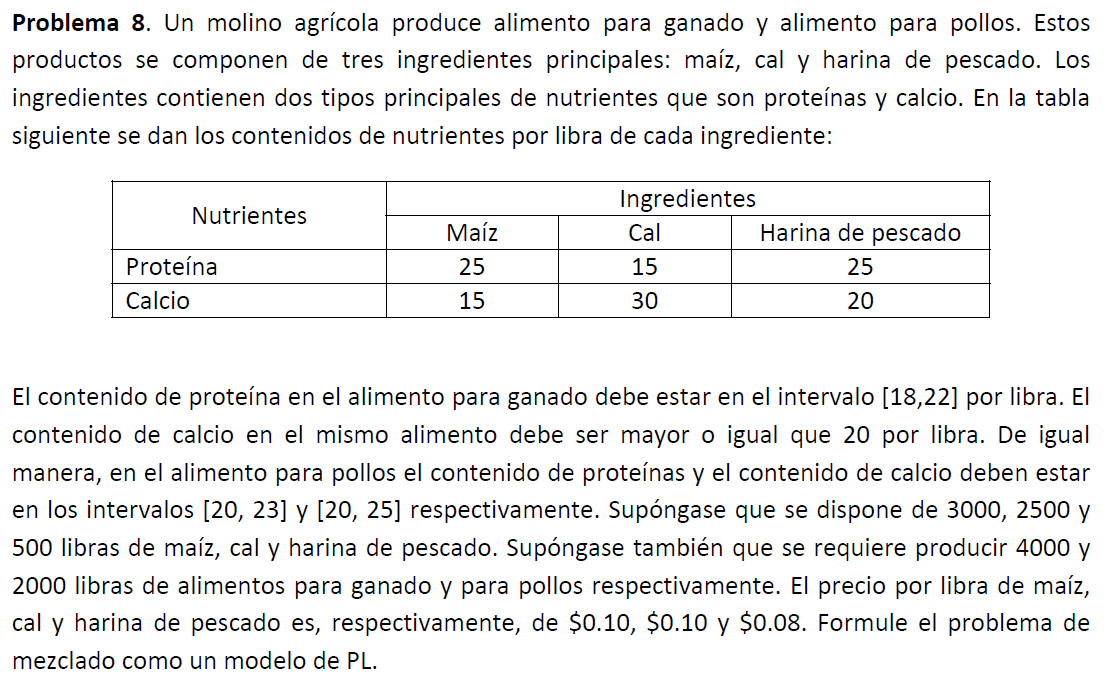

## Sets
I es el conjunto de ingredientes (i = 1 es maíz, i = 2 es cal, i = 3 es harina de pescado)\
J es el conjunto de alimentos (j = 1 es ganado, j = 2 es pollos)\
K es el conjunto de nutrientes (k = 1 es proteina, k = 2 es calcio)

In [1]:
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
model = pe.ConcreteModel()

In [3]:
model.I = pe.RangeSet(1,3)
model.J = pe.RangeSet(1,2)
model.K = pe.RangeSet(1,2)

## Parameters
Precioi es el precio unitario por libra del tipo de ingrediente i (dolar/lb)\
Reqj es el requerimiento mínimo a producir del tipo de alimento j en libras (lb)\
Invi es la cantidad de libras del tipo de ingrediente i disponibles en inventario (lb)\
Contki es el contenido del nutriente k por libra del tipo de ingrediente i (unidad/lb)\
ContMinkj es la cantidad mínima del nutriente k contenida por libra en el tipo de alimento j (unidad/lb)\
ContMaxkj es la cantidad máxima del nutriente k contenida por libra en el tipo de alimento j (unidad/lb)

In [4]:
Precio = {1: 0.1, 2: 0.1, 3: 0.08}
Req = {1: 4000, 2: 2000}
Inv = {1: 3000, 2: 2500, 3: 500}
Cont = {(1,1): 25,   (1,2): 15,    (1,3): 25, 
        (2,1): 15,   (2,2): 30,    (2,3): 20}
ContMin = {(1,1): 18,   (1,2): 20,     
           (2,1): 20,   (2,2): 20}
ContMax = {(1,1): 22,                   (1,2): 23,     
           (2,1): 999999999999999999,   (2,2): 25}

In [5]:
model.Precio = pe.Param(model.I, initialize = Precio) #Precio unitario
model.Req = pe.Param(model.J, initialize = Req) #Requerimiento mínimo
model.Inv = pe.Param(model.I, initialize = Inv) #Inventario
model.Cont = pe.Param(model.K, model.I, initialize = Cont) #Contenido de nutriente por libra de ingrediente
model.ContMin = pe.Param(model.K, model.J, initialize = ContMin) #Contenido mínimo
model.ContMax = pe.Param(model.K, model.J, initialize = ContMax) #Contenido máximo

## Variables
xij es la cantidad de libras del tipo de ingrediente i usadas para producir el tipo de alimento j

In [6]:
model.x = pe.Var(model.I, model.J, domain = pe.NonNegativeReals)

## Objective

In [7]:
Z = sum(model.Precio[i] * model.x[i,j]
        for i in model.I for j in model.J)
model.objective = pe.Objective(sense = pe.minimize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.1*x[1,1] + 0.1*x[1,2] + 0.1*x[2,1] + 0.1*x[2,2] + 0.08*x[3,1] + 0.08*x[3,2]


## Constraints

In [8]:
#Contenido mínimo
model.contenidominimo = pe.ConstraintList()
for j in model.J:
    for k in model.K:
        contmin_lhs = sum(model.Cont[k,i] * model.x[i,j] for i in model.I)
        contmin_rhs = model.ContMin[k,j] * sum(model.x[i,j] for i in model.I)
        model.contenidominimo.add(contmin_lhs >= contmin_rhs)
model.contenidominimo.pprint()

contenidominimo : Size=4, Index=contenidominimo_index, Active=True
    Key : Lower : Body                                                                : Upper : Active
      1 :  -Inf : 18*(x[1,1] + x[2,1] + x[3,1]) - (25*x[1,1] + 15*x[2,1] + 25*x[3,1]) :   0.0 :   True
      2 :  -Inf : 20*(x[1,1] + x[2,1] + x[3,1]) - (15*x[1,1] + 30*x[2,1] + 20*x[3,1]) :   0.0 :   True
      3 :  -Inf : 20*(x[1,2] + x[2,2] + x[3,2]) - (25*x[1,2] + 15*x[2,2] + 25*x[3,2]) :   0.0 :   True
      4 :  -Inf : 20*(x[1,2] + x[2,2] + x[3,2]) - (15*x[1,2] + 30*x[2,2] + 20*x[3,2]) :   0.0 :   True


In [9]:
#Contenido máximo
model.contenidomaximo = pe.ConstraintList()
for j in model.J:
    for k in model.K:
        contmax_lhs = sum(model.Cont[k,i] * model.x[i,j] for i in model.I)
        contmax_rhs = model.ContMax[k,j] * sum(model.x[i,j] for i in model.I)
        model.contenidomaximo.add(contmax_lhs <= contmax_rhs)
model.contenidomaximo.pprint()

contenidomaximo : Size=4, Index=contenidomaximo_index, Active=True
    Key : Lower : Body                                                                              : Upper : Active
      1 :  -Inf :                 25*x[1,1] + 15*x[2,1] + 25*x[3,1] - 22*(x[1,1] + x[2,1] + x[3,1]) :   0.0 :   True
      2 :  -Inf : 15*x[1,1] + 30*x[2,1] + 20*x[3,1] - 999999999999999999*(x[1,1] + x[2,1] + x[3,1]) :   0.0 :   True
      3 :  -Inf :                 25*x[1,2] + 15*x[2,2] + 25*x[3,2] - 23*(x[1,2] + x[2,2] + x[3,2]) :   0.0 :   True
      4 :  -Inf :                 15*x[1,2] + 30*x[2,2] + 20*x[3,2] - 25*(x[1,2] + x[2,2] + x[3,2]) :   0.0 :   True


In [10]:
#Inventario
model.Inventario = pe.ConstraintList()
for i in model.I:
    inv_lhs = sum(model.x[i,j] for j in model.J)
    inv_rhs = model.Inv[i]
    model.Inventario.add(inv_lhs <= inv_rhs)
model.Inventario.pprint()

Inventario : Size=3, Index=Inventario_index, Active=True
    Key : Lower : Body            : Upper  : Active
      1 :  -Inf : x[1,1] + x[1,2] : 3000.0 :   True
      2 :  -Inf : x[2,1] + x[2,2] : 2500.0 :   True
      3 :  -Inf : x[3,1] + x[3,2] :  500.0 :   True


In [11]:
#Requerimiento
model.requerimiento = pe.ConstraintList()
for j in model.J:
    req_lhs = sum(model.x[i,j] for i in model.I)
    req_rhs = model.Req[j]
    model.requerimiento.add(req_lhs <= req_rhs)
model.requerimiento.pprint()

requerimiento : Size=2, Index=requerimiento_index, Active=True
    Key : Lower : Body                     : Upper  : Active
      1 :  -Inf : x[1,1] + x[2,1] + x[3,1] : 4000.0 :   True
      2 :  -Inf : x[1,2] + x[2,2] + x[3,2] : 2000.0 :   True


## Solver

In [13]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp3osdg85k.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmprh01ojko.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpeijhc8r1.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpeijhc8r1.pyomo.lp'...
14 rows, 7 columns, 35 non-zeros
97 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmprh01ojko.glpk.glp'...
79 lines were written
GLPK Simplex Optimizer 5.0
14 rows, 7 columns, 35 non-zeros
Preprocessing...
12 rows, 6 columns, 31 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+01  ratio =  1.000e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12
*     0: obj =   0.000000000e+00 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (43927 bytes)
Writing basic solution to 'C:\Use

In [14]:
for i in model.I:
    for j in model.J:
        print(pe.value(model.x[i,j]))
print(pe.value(model.objective))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
